<a href="https://colab.research.google.com/github/kunan-au/Modeling_Risk/blob/main/Feature_Engineering_Doing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Seeking Factors

Minimize

Model using


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Package

In [3]:
!pip install requests pandas matplotlib scipy statsmodels
!pip install yfinance

In [4]:
import requests
import pandas as pd
import gspread
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
from google.auth import default
import statsmodels.api as sm
from scipy import stats
import yfinance as yf
import getpass

Data Importing

In [5]:
#Setup for Google Sheets API
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [6]:
def get_sheet_data(spreadsheet_name, worksheet_index=0):
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()
    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.drop(0)

    # Print columns to debug
    print("Columns in DataFrame:", df.columns)

    # Check if 'Date' column exists
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'].str.split().str[0], format='%m/%d/%Y').dt.date
    else:
        print(f"'Date' column not found in {spreadsheet_name}")

    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            print(f"'{col}' column not found in {spreadsheet_name}")

    return df

In [7]:
sheet_names = ["MSFT", "META", "NFLX"]

dataframes = [get_sheet_data(name) for name in sheet_names]
combined_df = pd.concat(dataframes, ignore_index=True)

for df in dataframes:
    print(df.head())

Columns in DataFrame: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name=0)
Columns in DataFrame: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name=0)
Columns in DataFrame: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name=0)
0        Date    Open    High     Low   Close    Volume
1  2022-01-03  335.35  338.00  329.78  334.75  28918013
2  2022-01-04  334.83  335.20  326.12  329.01  32674306
3  2022-01-05  325.86  326.07  315.98  316.38  40054327
4  2022-01-06  313.15  318.70  311.49  313.88  39646148
5  2022-01-07  314.15  316.50  310.09  314.04  32720018
0        Date    Open    High     Low   Close    Volume
1  2022-01-03  338.30  341.08  337.19  338.54  14562849
2  2022-01-04  339.95  343.09  331.87  336.53  15997974
3  2022-01-05  333.02  335.76  323.84  324.17  20564521
4  2022-01-06  322.82  339.17  322.72  332.46  27962809
5  2022-01-07  332.74  337.00  328.88  331.79  14722020
0        Date   

In [8]:
def get_sheet_data_updated(spreadsheet_name, worksheet_index=0):
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()

    # The first row is the header
    header = data[0]
    # The first column 'Year' has no header, add it manually
    header[0] = 'Year'

    df = pd.DataFrame(data[1:], columns=header)

    # Convert 'Year' to datetime format
    if 'Annual' in spreadsheet_name:
        # Annual data, set 'Year' as the end of each year to forward fill
        df['Year'] = pd.to_datetime(df['Year']+'-12-31')
    else:
        # Monthly data
        df['Year'] = pd.to_datetime(df['Year'], format='%Y%m')

    # Convert numeric columns
    numeric_columns = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

In [9]:
# Load the data
sheet_name_factors = ['F-F_Research_Data_5_Annual_Factors_2x3', 'F-F_Research_Data_5_Month_Factors_2x3']
factorframes = [get_sheet_data_updated(name) for name in sheet_name_factors]

# Ensure 'Year' column is datetime for both dataframes
factorframes[0]['Year'] = pd.to_datetime(factorframes[0]['Year'], format='%Y')
factorframes[1]['Year'] = pd.to_datetime(factorframes[1]['Year'], format='%Y%m')

# Set the index to 'Year' and sort it
annual_data = factorframes[0].set_index('Year').sort_index()
monthly_data = factorframes[1].set_index('Year').sort_index()

# Resample annual data to monthly, filling forward
# Note: The annual data is on the last day of the year, so we need to shift it to the first day
annual_data = annual_data.resample('MS').ffill()

# Combine the data
combined_data = pd.concat([monthly_data, annual_data]).sort_index().fillna(method='ffill')

# Reset the index if needed
combined_data = combined_data.reset_index()

# Print combined data to check
print(combined_data.head())

        Year  Mkt-RF   SMB   HML   RMW   CMA    RF
0 1963-07-01   -0.39 -0.41 -0.97  0.68 -1.18  0.27
1 1963-08-01    5.07 -0.80  1.80  0.36 -0.35  0.25
2 1963-09-01   -1.57 -0.52  0.13 -0.71  0.29  0.27
3 1963-10-01    2.53 -1.39 -0.10  2.80 -2.01  0.29
4 1963-11-01   -0.85 -0.88  1.75 -0.51  2.24  0.27


Basic

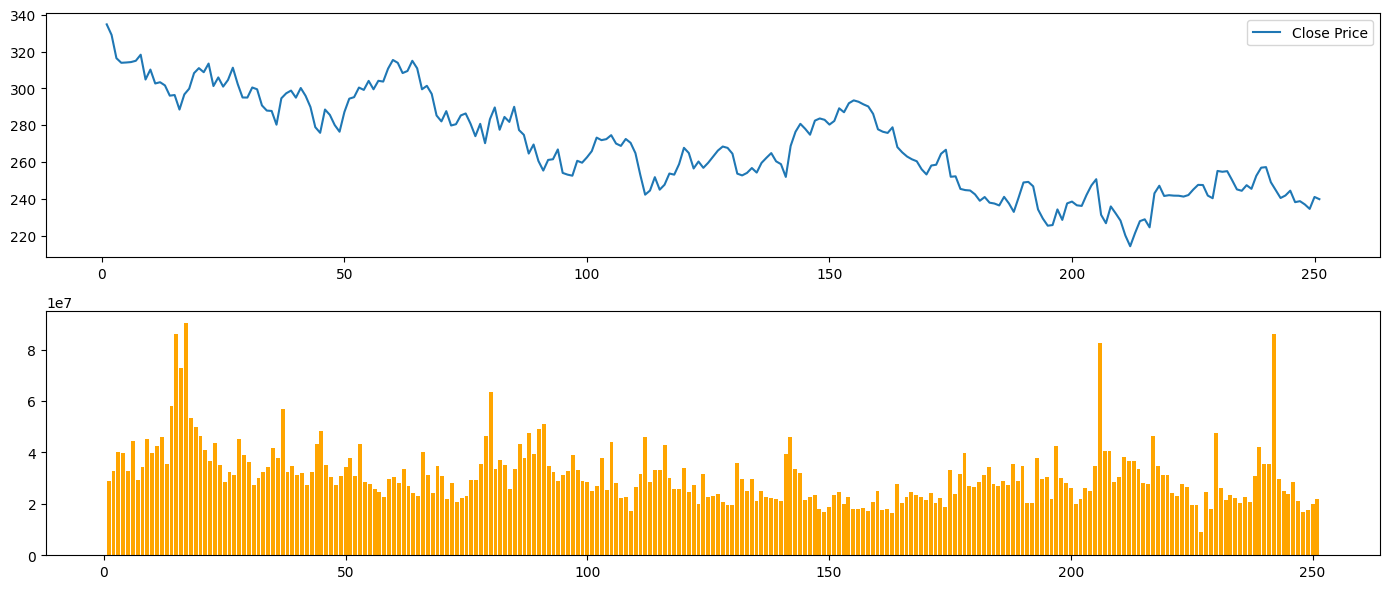

Daily Closing Prices for MSFT
Daily Volume for MSFT


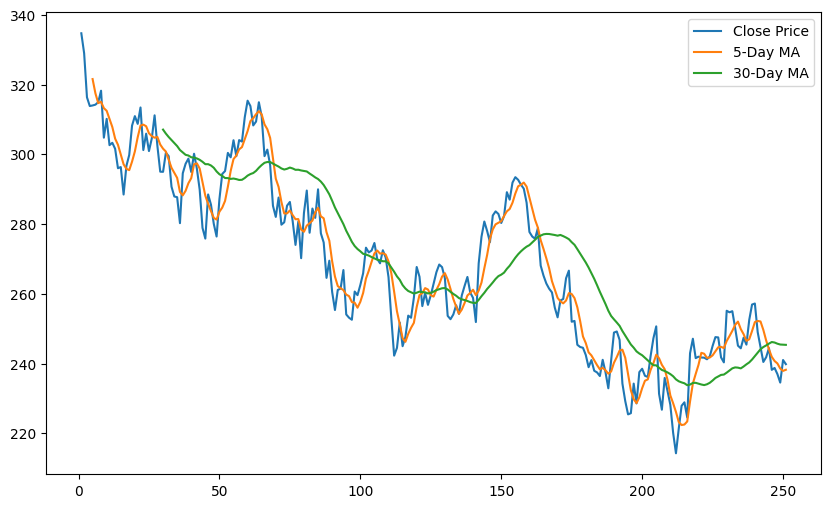

Moving Averages for MSFT


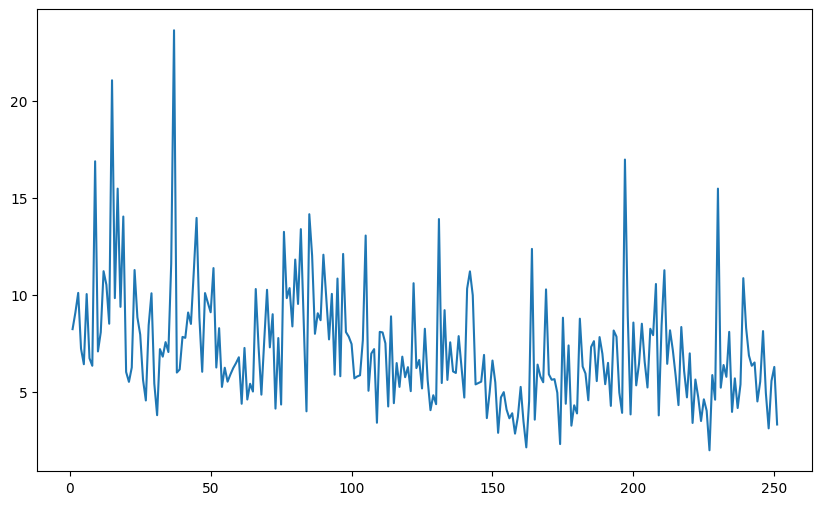

Price Fluctuation for MSFT


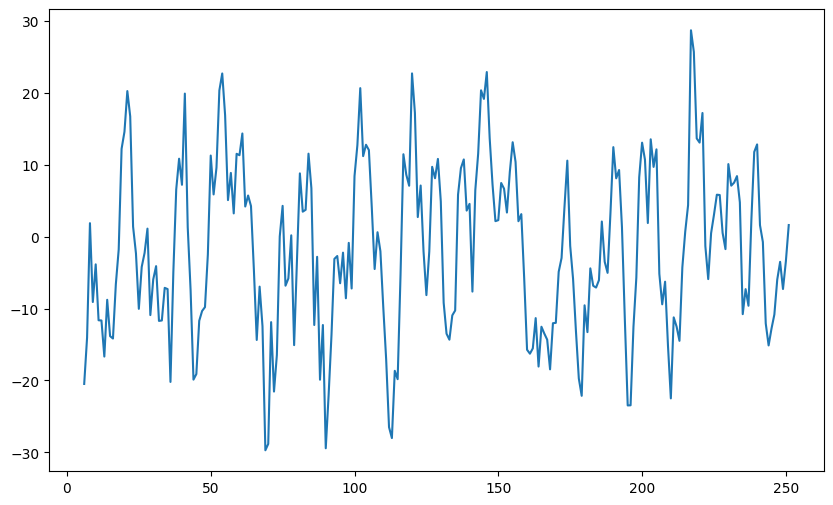

Momentum for MSFT


<ipython-input-10-26315a730645>:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


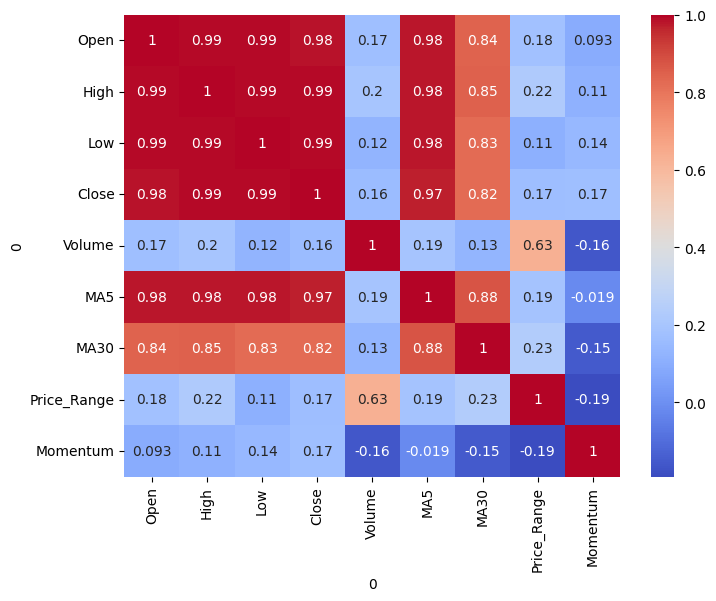

Correlation Heatmap for MSFT


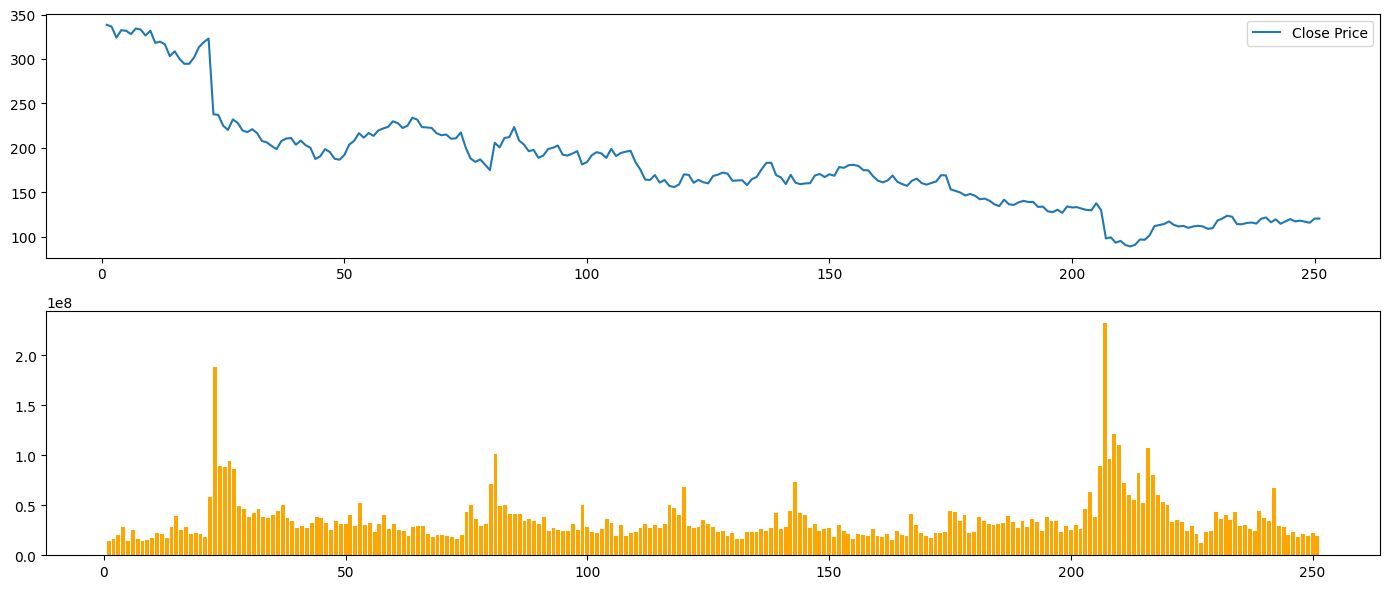

Daily Closing Prices for META
Daily Volume for META


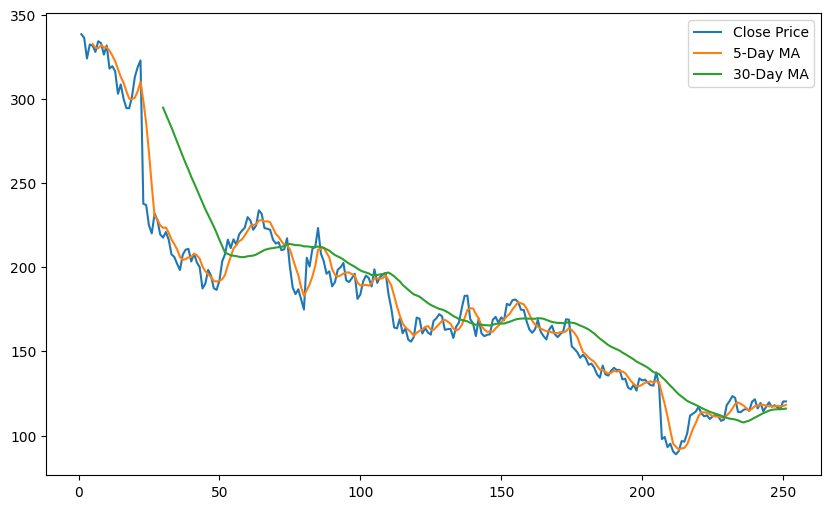

Moving Averages for META


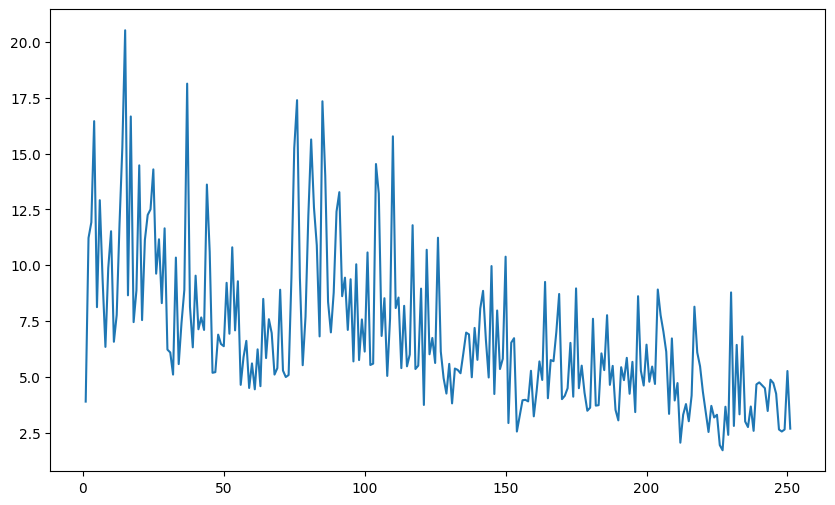

Price Fluctuation for META


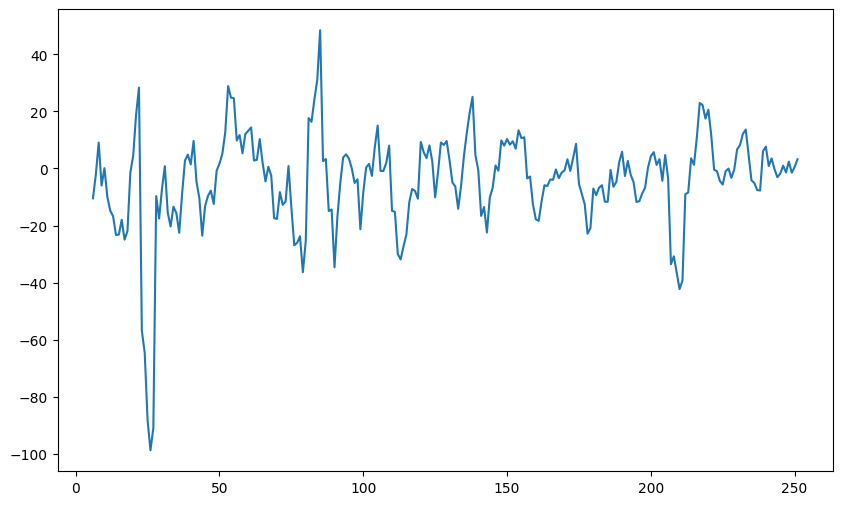

Momentum for META


<ipython-input-10-26315a730645>:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


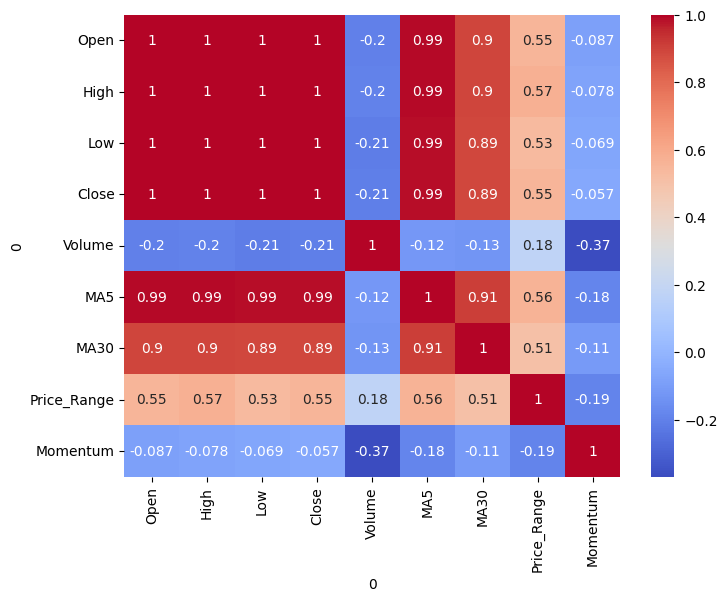

Correlation Heatmap for META


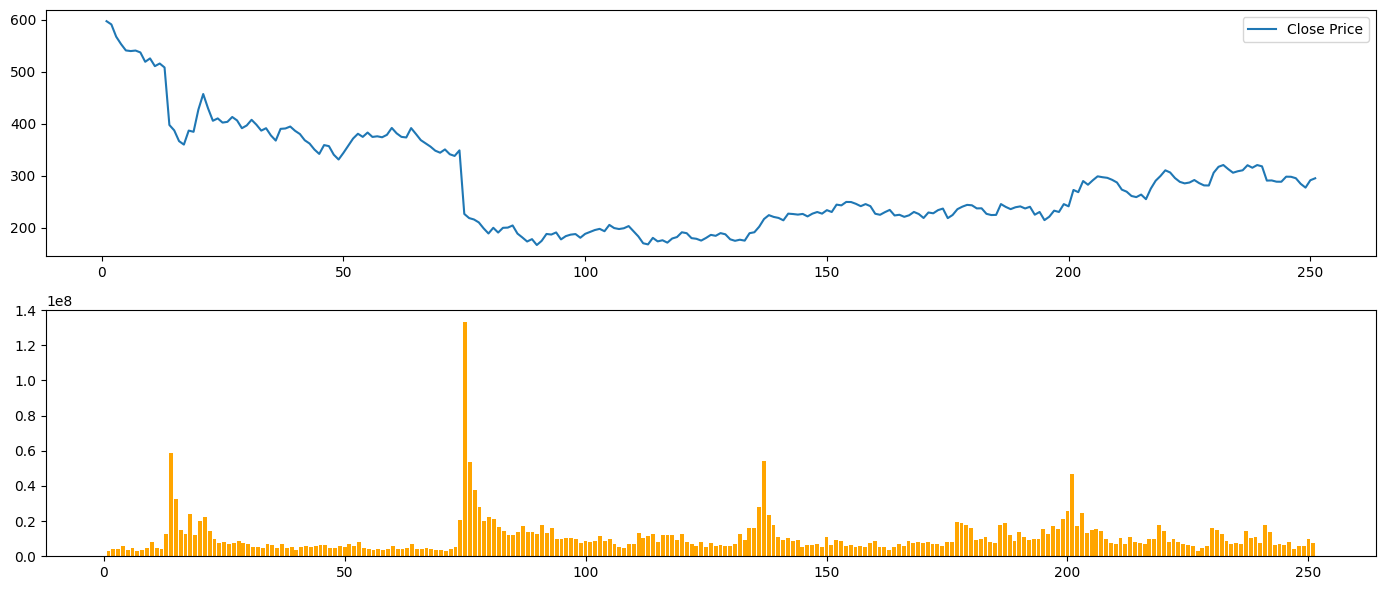

Daily Closing Prices for NFLX
Daily Volume for NFLX


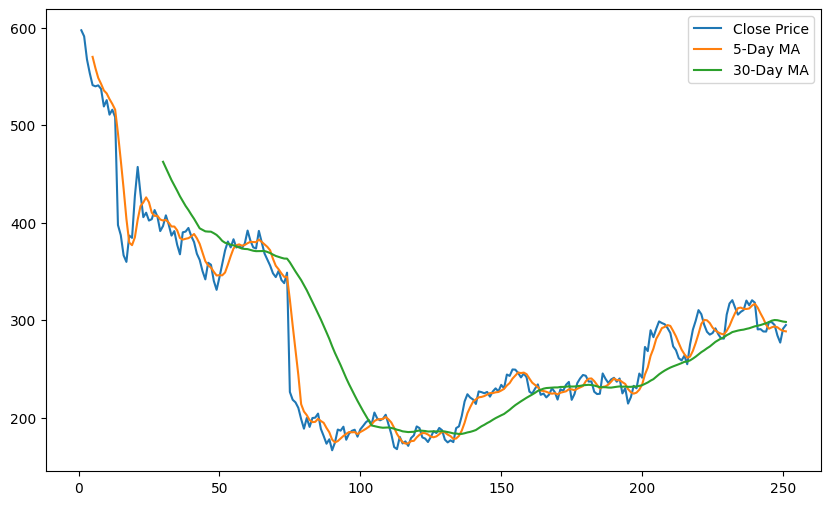

Moving Averages for NFLX


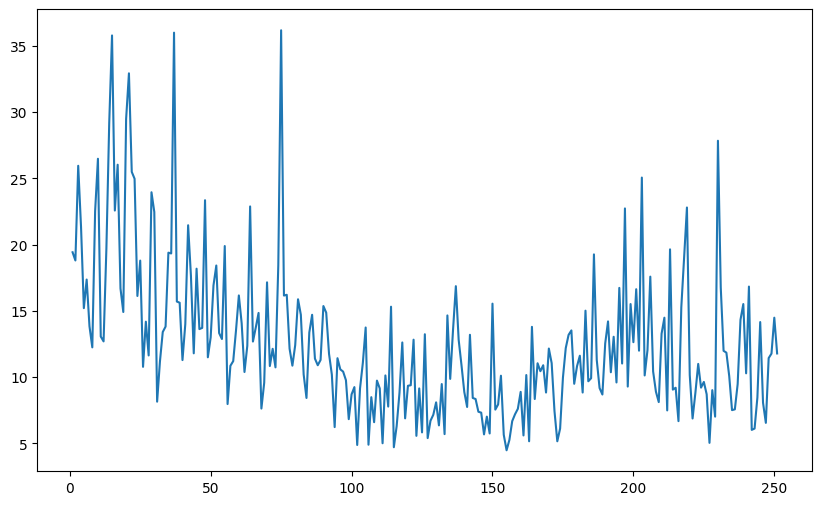

Price Fluctuation for NFLX


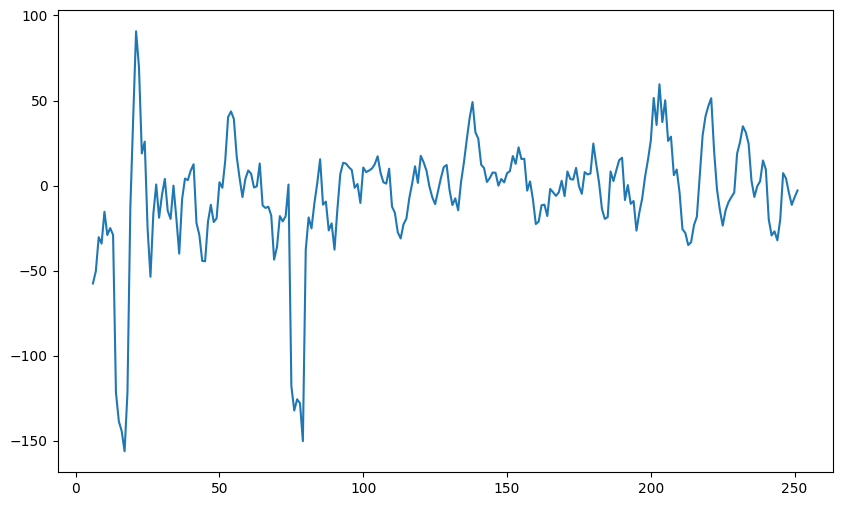

Momentum for NFLX


<ipython-input-10-26315a730645>:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


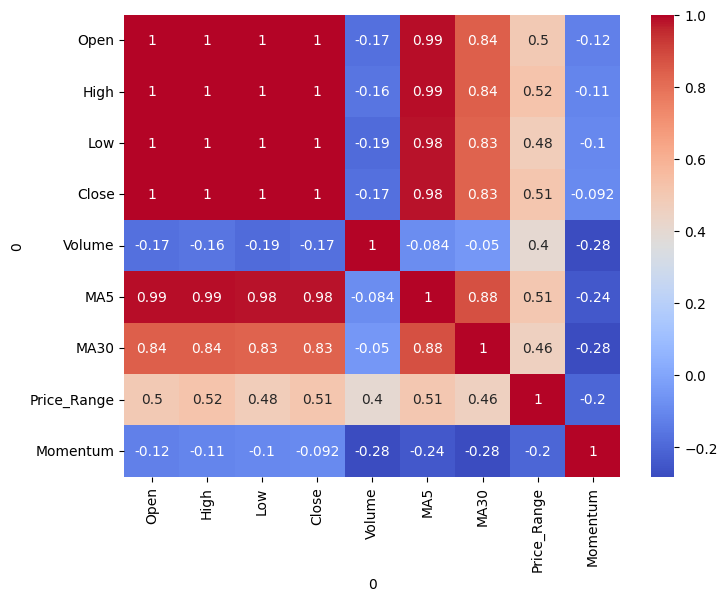

Correlation Heatmap for NFLX


In [10]:
# Price and Volume Plot for all DataFrames
for df, name in zip(dataframes, sheet_names):
    # Price and Volume Plot
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.bar(df.index, df['Volume'], color='orange')
    plt.tight_layout()
    plt.show()
    print(f'Daily Closing Prices for {name}')
    print(f'Daily Volume for {name}')

    # Moving Average Plot
    plt.figure(figsize=(10, 6))
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA30'] = df['Close'].rolling(window=30).mean()
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['MA5'], label='5-Day MA')
    plt.plot(df['MA30'], label='30-Day MA')
    plt.legend()
    plt.show()
    print(f'Moving Averages for {name}')

    # Price Fluctuation Plot
    plt.figure(figsize=(10, 6))
    df['Price_Range'] = df['High'] - df['Low']
    plt.plot(df['Price_Range'])
    plt.show()
    print(f'Price Fluctuation for {name}')

    # Momentum Plot
    plt.figure(figsize=(10, 6))
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    plt.plot(df['Momentum'])
    plt.show()
    print(f'Momentum for {name}')

    # Correlation Heatmap
    plt.figure(figsize=(8, 6))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.show()
    print(f'Correlation Heatmap for {name}')

In [11]:
# Calculate daily returns for each asset
returns_dict = {}

for asset_name, df in zip(sheet_names, dataframes):
    df['Returns'] = df['Close'].pct_change()
    returns_dict[asset_name] = df[['Date', 'Returns']].copy()

# Print the returns for each asset
for asset_name, returns_df in returns_dict.items():
    print(f"Asset: {asset_name}")
    print(returns_df.head())
    print("\n")


Asset: MSFT
0        Date   Returns
1  2022-01-03       NaN
2  2022-01-04 -0.017147
3  2022-01-05 -0.038388
4  2022-01-06 -0.007902
5  2022-01-07  0.000510


Asset: META
0        Date   Returns
1  2022-01-03       NaN
2  2022-01-04 -0.005937
3  2022-01-05 -0.036728
4  2022-01-06  0.025573
5  2022-01-07 -0.002015


Asset: NFLX
0        Date   Returns
1  2022-01-03       NaN
2  2022-01-04 -0.010412
3  2022-01-05 -0.039973
4  2022-01-06 -0.025074
5  2022-01-07 -0.022104




In [12]:
def get_alpha_vantage_data(symbol, api_key, function="TIME_SERIES_DAILY"):
    base_url = "https://www.alphavantage.co/query"
    params = {
        "function": function,
        "symbol": symbol,
        "apikey": api_key,
        "datatype": "json"
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    return data

In [13]:
def process_alpha_vantage_data(data):
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df.apply(pd.to_numeric)
    df.index = pd.to_datetime(df.index)
    return df

In [14]:
api_key = getpass.getpass("Please enter Alpha Vantage API key:")
symbol = "MSFT", "META", "NFLX"

raw_data = get_alpha_vantage_data(symbol, api_key)
print(raw_data)
df = process_alpha_vantage_data(raw_data)

Please enter Alpha Vantage API key:··········
{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'NFLX', '3. Last Refreshed': '2024-01-19', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2024-01-19': {'1. open': '484.9800', '2. high': '485.6700', '3. low': '476.0600', '4. close': '482.9500', '5. volume': '5672351'}, '2024-01-18': {'1. open': '480.0300', '2. high': '485.7700', '3. low': '478.0200', '4. close': '485.3100', '5. volume': '4054399'}, '2024-01-17': {'1. open': '484.5000', '2. high': '486.2100', '3. low': '475.2642', '4. close': '480.3300', '5. volume': '4894593'}, '2024-01-16': {'1. open': '490.0000', '2. high': '494.1500', '3. low': '478.0200', '4. close': '481.2400', '5. volume': '4678974'}, '2024-01-12': {'1. open': '500.5100', '2. high': '500.7900', '3. low': '490.6100', '4. close': '492.1600', '5. volume': '5003718'}, '2024-01-11': {'1. open': '492.5400', '2. high': '503.4100', '3. low

In [15]:
def get_sp500_data(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    return sp500

sp500_df = get_sp500_data('2022-01-01', '2022-12-30')

print(sp500_df.head())

market_returns = sp500_df['Close'].pct_change()

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-01-03  4778.140137  4796.640137  4758.169922  4796.560059  4796.560059   
2022-01-04  4804.509766  4818.620117  4774.270020  4793.540039  4793.540039   
2022-01-05  4787.990234  4797.700195  4699.439941  4700.580078  4700.580078   
2022-01-06  4693.390137  4725.009766  4671.259766  4696.049805  4696.049805   
2022-01-07  4697.660156  4707.950195  4662.740234  4677.029785  4677.029785   

                Volume  
Date                    
2022-01-03  3831020000  
2022-01-04  4683170000  
2022-01-05  4887960000  
2022-01-06  4295280000  
2022-01-07  4181510000  


ADV

In [16]:
def get_risk_factors(start_date, end_date):
    try:
        ff_factors = yf.download("F-F_Research_Data_Factors_daily", start=start_date, end=end_date)

        if len(ff_factors.columns) == 4:
            ff_factors.columns = ['Market Risk Premium', 'SMB', 'HML', 'Risk Free Rate']
        elif len(ff_factors.columns) == 6:
            ff_factors.columns = ['Market Risk Premium', 'SMB', 'HML', 'Risk Free Rate', 'Column5', 'Column6']

        ff_factors = ff_factors / 100

        return ff_factors
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

Empty Sheet

In [17]:
start_date = '2022-01-01'
end_date = '2022-12-31'
risk_factors = get_risk_factors(start_date, end_date)

if risk_factors is not None:
    print(risk_factors.head())
else:
    print("Failed to download risk factors.")

[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['F-F_RESEARCH_DATA_FACTORS_DAILY']: Exception('%ticker%: No timezone found, symbol may be delisted')


Empty DataFrame
Columns: [Market Risk Premium, SMB, HML, Risk Free Rate, Column5, Column6]
Index: []


In [18]:
def calculate_asset_returns(df):
    asset_returns = df['Close'].pct_change().dropna()

    return asset_returns

In [19]:
def calculate_and_visualize_volatility(df, window=20):
    returns = df['Close'].pct_change().dropna()
    volatility = returns.rolling(window=window).std()
    plt.figure(figsize=(10, 6))
    plt.plot(volatility, label='Volatility')
    plt.title('Volatility Factor')
    plt.legend()
    plt.show()

In [20]:
def calculate_alpha_and_beta(asset_returns, market_returns):
    slope, intercept, r_value, p_value, std_err = stats.linregress(asset_returns, market_returns)
    alpha = intercept
    beta = slope
    return alpha, beta

In [21]:
def calculate_and_visualize_sharpe_ratio(df, risk_free_rate=0.02):
    returns = df['Close'].pct_change().dropna()
    mean_return = returns.mean()
    volatility = returns.std()
    sharpe_ratio = (mean_return - risk_free_rate) / volatility

    plt.figure(figsize=(10, 6))
    plt.plot(returns, label='Asset Returns')
    plt.title('Asset Returns')
    plt.legend()
    plt.show()

    print(f'Sharpe Ratio: {sharpe_ratio}')

In [22]:
def calculate_and_visualize_r_squared(asset_returns, market_returns):
    r_squared = np.corrcoef(asset_returns, market_returns)[0, 1] ** 2
    print(f'R-Squared Value: {r_squared}')

In [23]:
def calculate_and_visualize_technical_indicator(df, indicator='MA', window=20):
    if indicator == 'MA':
        df['Moving_Average'] = df['Close'].rolling(window=window).mean()
    elif indicator == 'RSI':
        delta = df['Close'].diff(1)
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        df['RSI'] = rsi
    elif indicator == 'Bollinger_Bands':
        df['MA'] = df['Close'].rolling(window=window).mean()
        df['Upper_Band'] = df['MA'] + 2 * df['Close'].rolling(window=window).std()
        df['Lower_Band'] = df['MA'] - 2 * df['Close'].rolling(window=window).std()

    plt.figure(figsize=(10, 6))
    if indicator == 'MA':
        plt.plot(df['Moving_Average'], label='Moving Average')
        plt.title('Moving Average')
    elif indicator == 'RSI':
        plt.plot(df['RSI'], label='RSI')
        plt.title('Relative Strength Index (RSI)')
    elif indicator == 'Bollinger_Bands':
        plt.plot(df['Close'], label='Close Price', alpha=0.5)
        plt.plot(df['Upper_Band'], label='Upper Bollinger Band')
        plt.plot(df['Lower_Band'], label='Lower Bollinger Band')
        plt.title('Bollinger Bands')
    plt.legend()
    plt.show()

In [24]:
def factor_model_analysis(asset_returns, market_returns, risk_factors):
    # Prepare the risk factors DataFrame with a constant for the OLS regression
    X = sm.add_constant(risk_factors)

    # Run the OLS regression
    model = sm.OLS(asset_returns, X).fit()

    # Print the summary of the regression
    print(model.summary())

    # Visualize the factor loadings
    plt.figure(figsize=(10, 6))
    plt.bar(X.columns[1:], model.params[1:])  # Skip the constant
    plt.xlabel('Risk Factors')
    plt.ylabel('Factor Loadings')
    plt.title('Factor Loadings for Asset Returns')
    plt.show()

In [25]:
def calculate_and_visualize_technical_indicator(df, indicator='MA', window=20):
    if indicator == 'MA':
        df['Moving_Average'] = df['Close'].rolling(window=window).mean()
        plt.figure(figsize=(10, 6))
        plt.plot(df['Moving_Average'], label='Moving Average')
        plt.title('Moving Average')
        plt.legend()

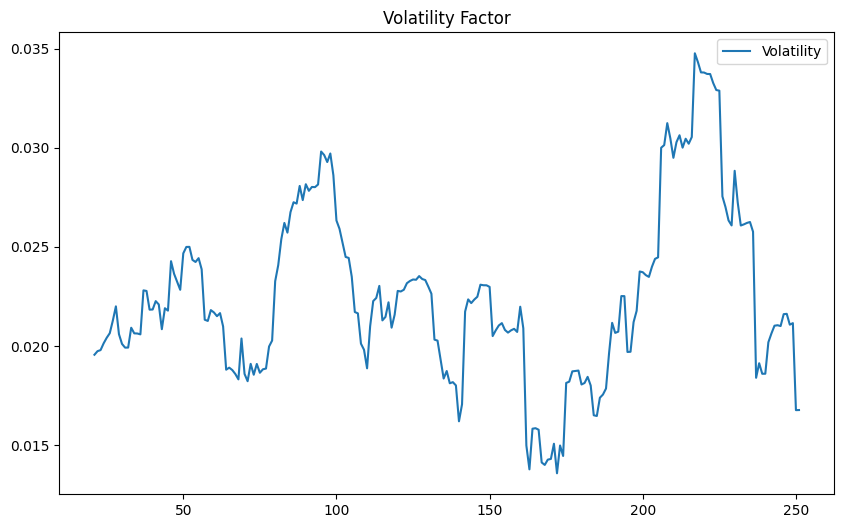

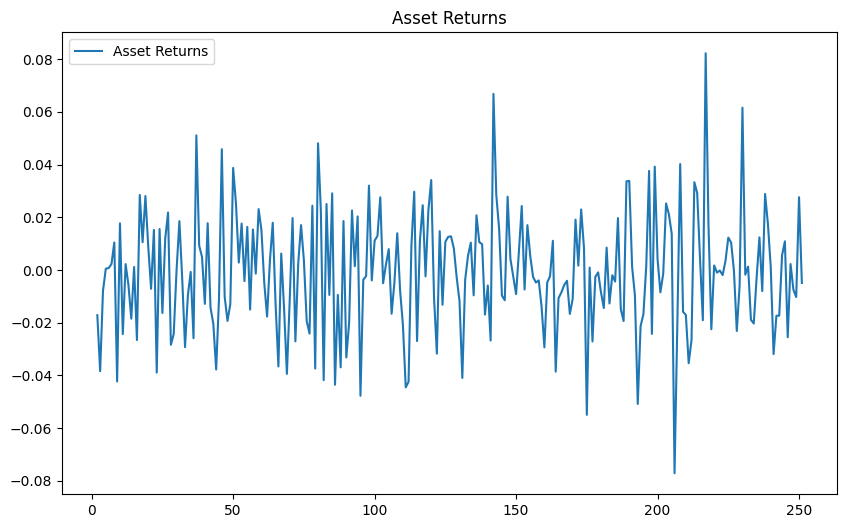

Sharpe Ratio: -0.9452074040104679
Alpha: nan, Beta: nan
R-Squared Value: nan
Risk factors are not in the DataFrame


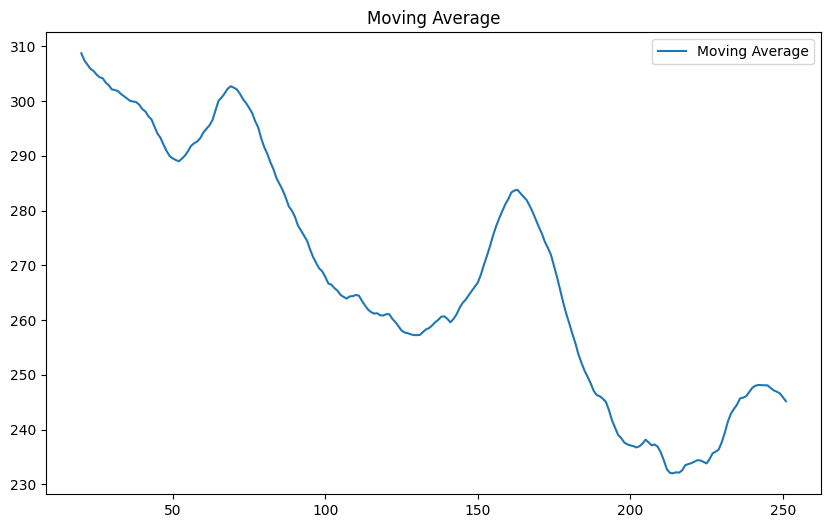

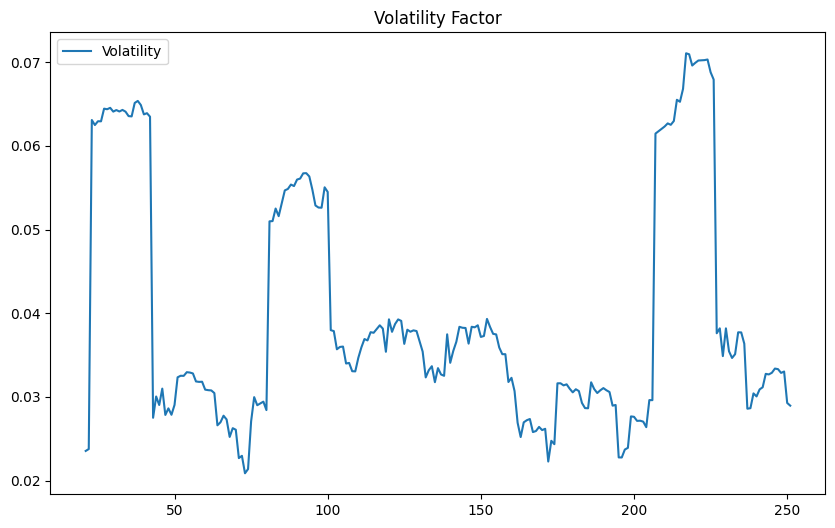

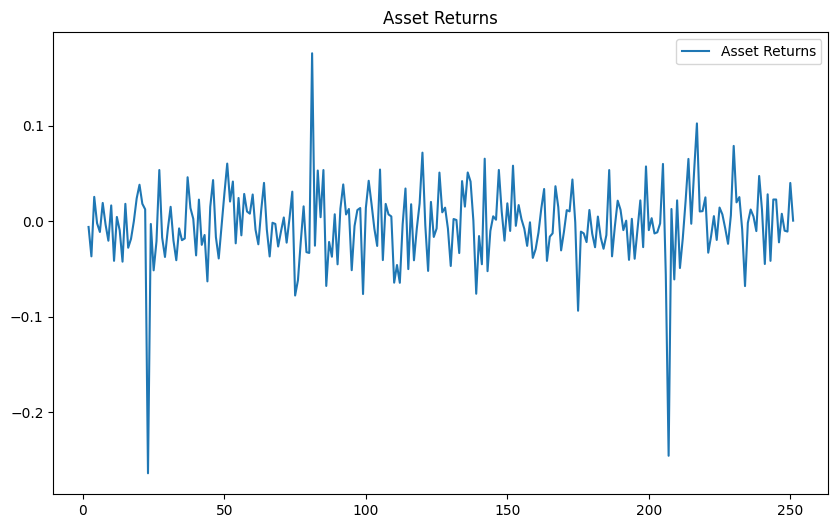

Sharpe Ratio: -0.5735995364551825
Alpha: nan, Beta: nan
R-Squared Value: nan
Risk factors are not in the DataFrame


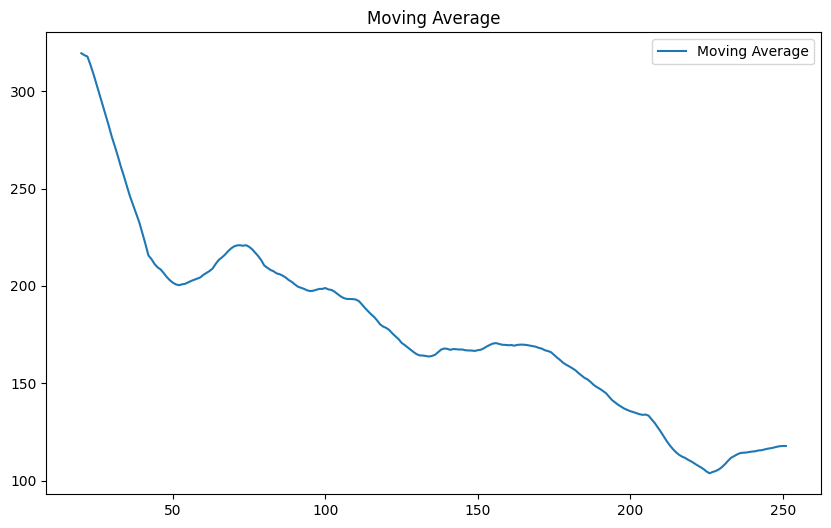

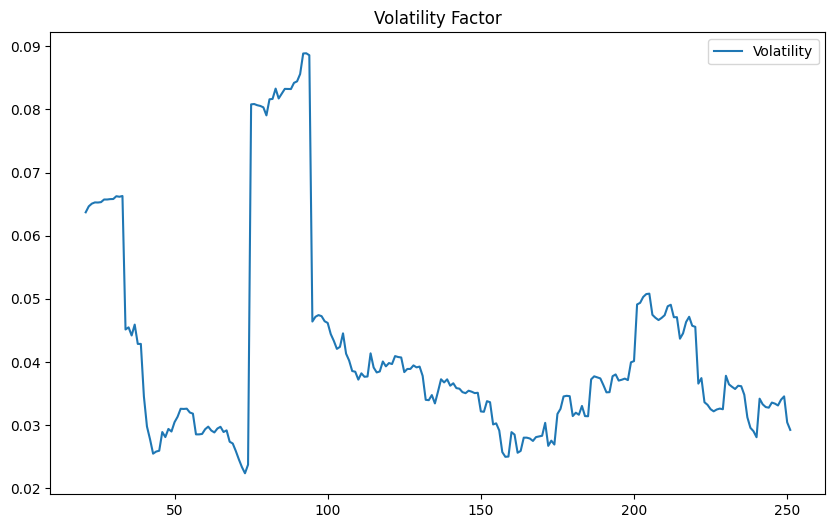

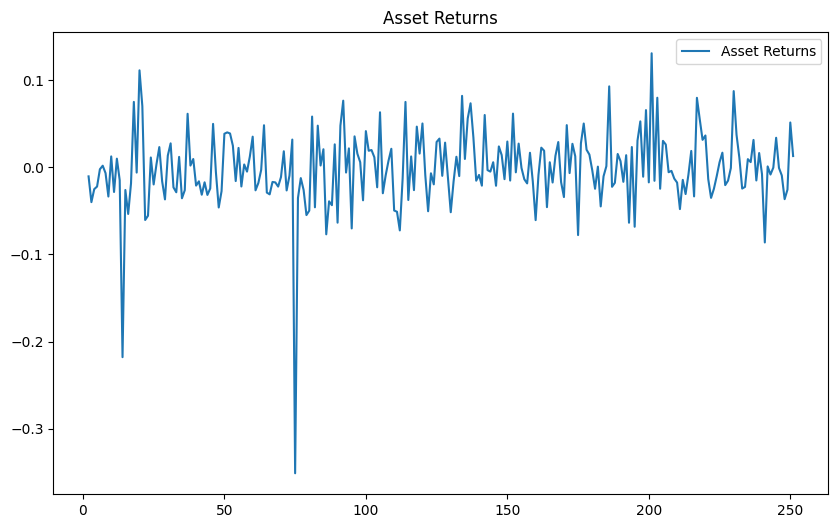

Sharpe Ratio: -0.4920564930469598
Alpha: nan, Beta: nan
R-Squared Value: nan
Risk factors are not in the DataFrame


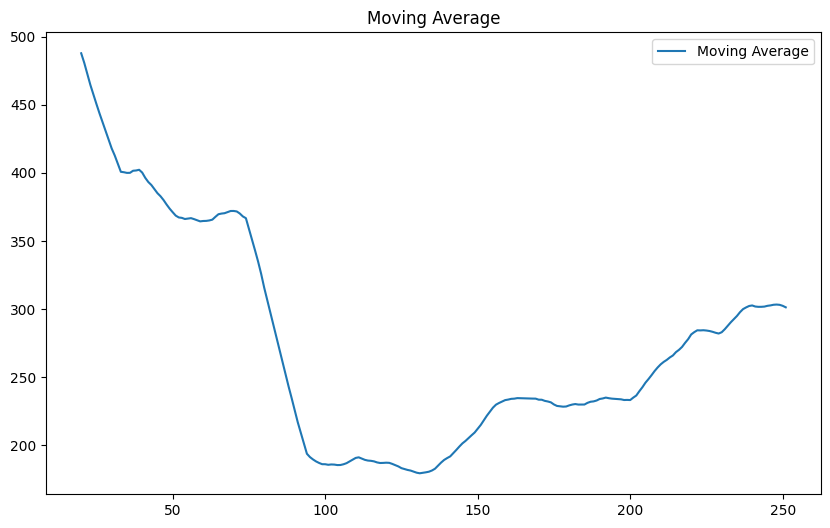

In [26]:
for df in dataframes:
    asset_returns = calculate_asset_returns(df)
    calculate_and_visualize_volatility(df)
    calculate_and_visualize_sharpe_ratio(df)

    alpha, beta = calculate_alpha_and_beta(asset_returns, market_returns)
    print(f"Alpha: {alpha}, Beta: {beta}")

    calculate_and_visualize_r_squared(asset_returns, market_returns)
    calculate_and_visualize_technical_indicator(df, 'MA')

    # Align asset_returns with risk_factors
    if 'risk_factors' not in df.columns:
        print("Risk factors are not in the DataFrame")
        continue

    risk_factors_aligned = risk_factors.loc[asset_returns.index]

    # Drop missing values
    asset_returns.dropna(inplace=True)
    risk_factors_aligned.dropna(inplace=True)

    # Ensure all inputs are aligned by index
    common_dates = asset_returns.index.intersection(risk_factors_aligned.index)
    asset_returns_aligned = asset_returns.loc[common_dates]
    risk_factors_aligned = risk_factors_aligned.loc[common_dates]

    # Run the factor model analysis
    factor_model_analysis(asset_returns_aligned, market_returns.loc[common_dates], risk_factors_aligned)

    # Print the head of the dataframe to check
    print(df.head())

TWO Stage

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


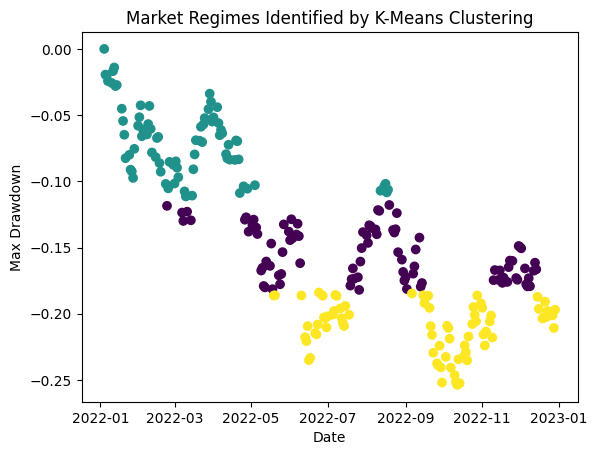

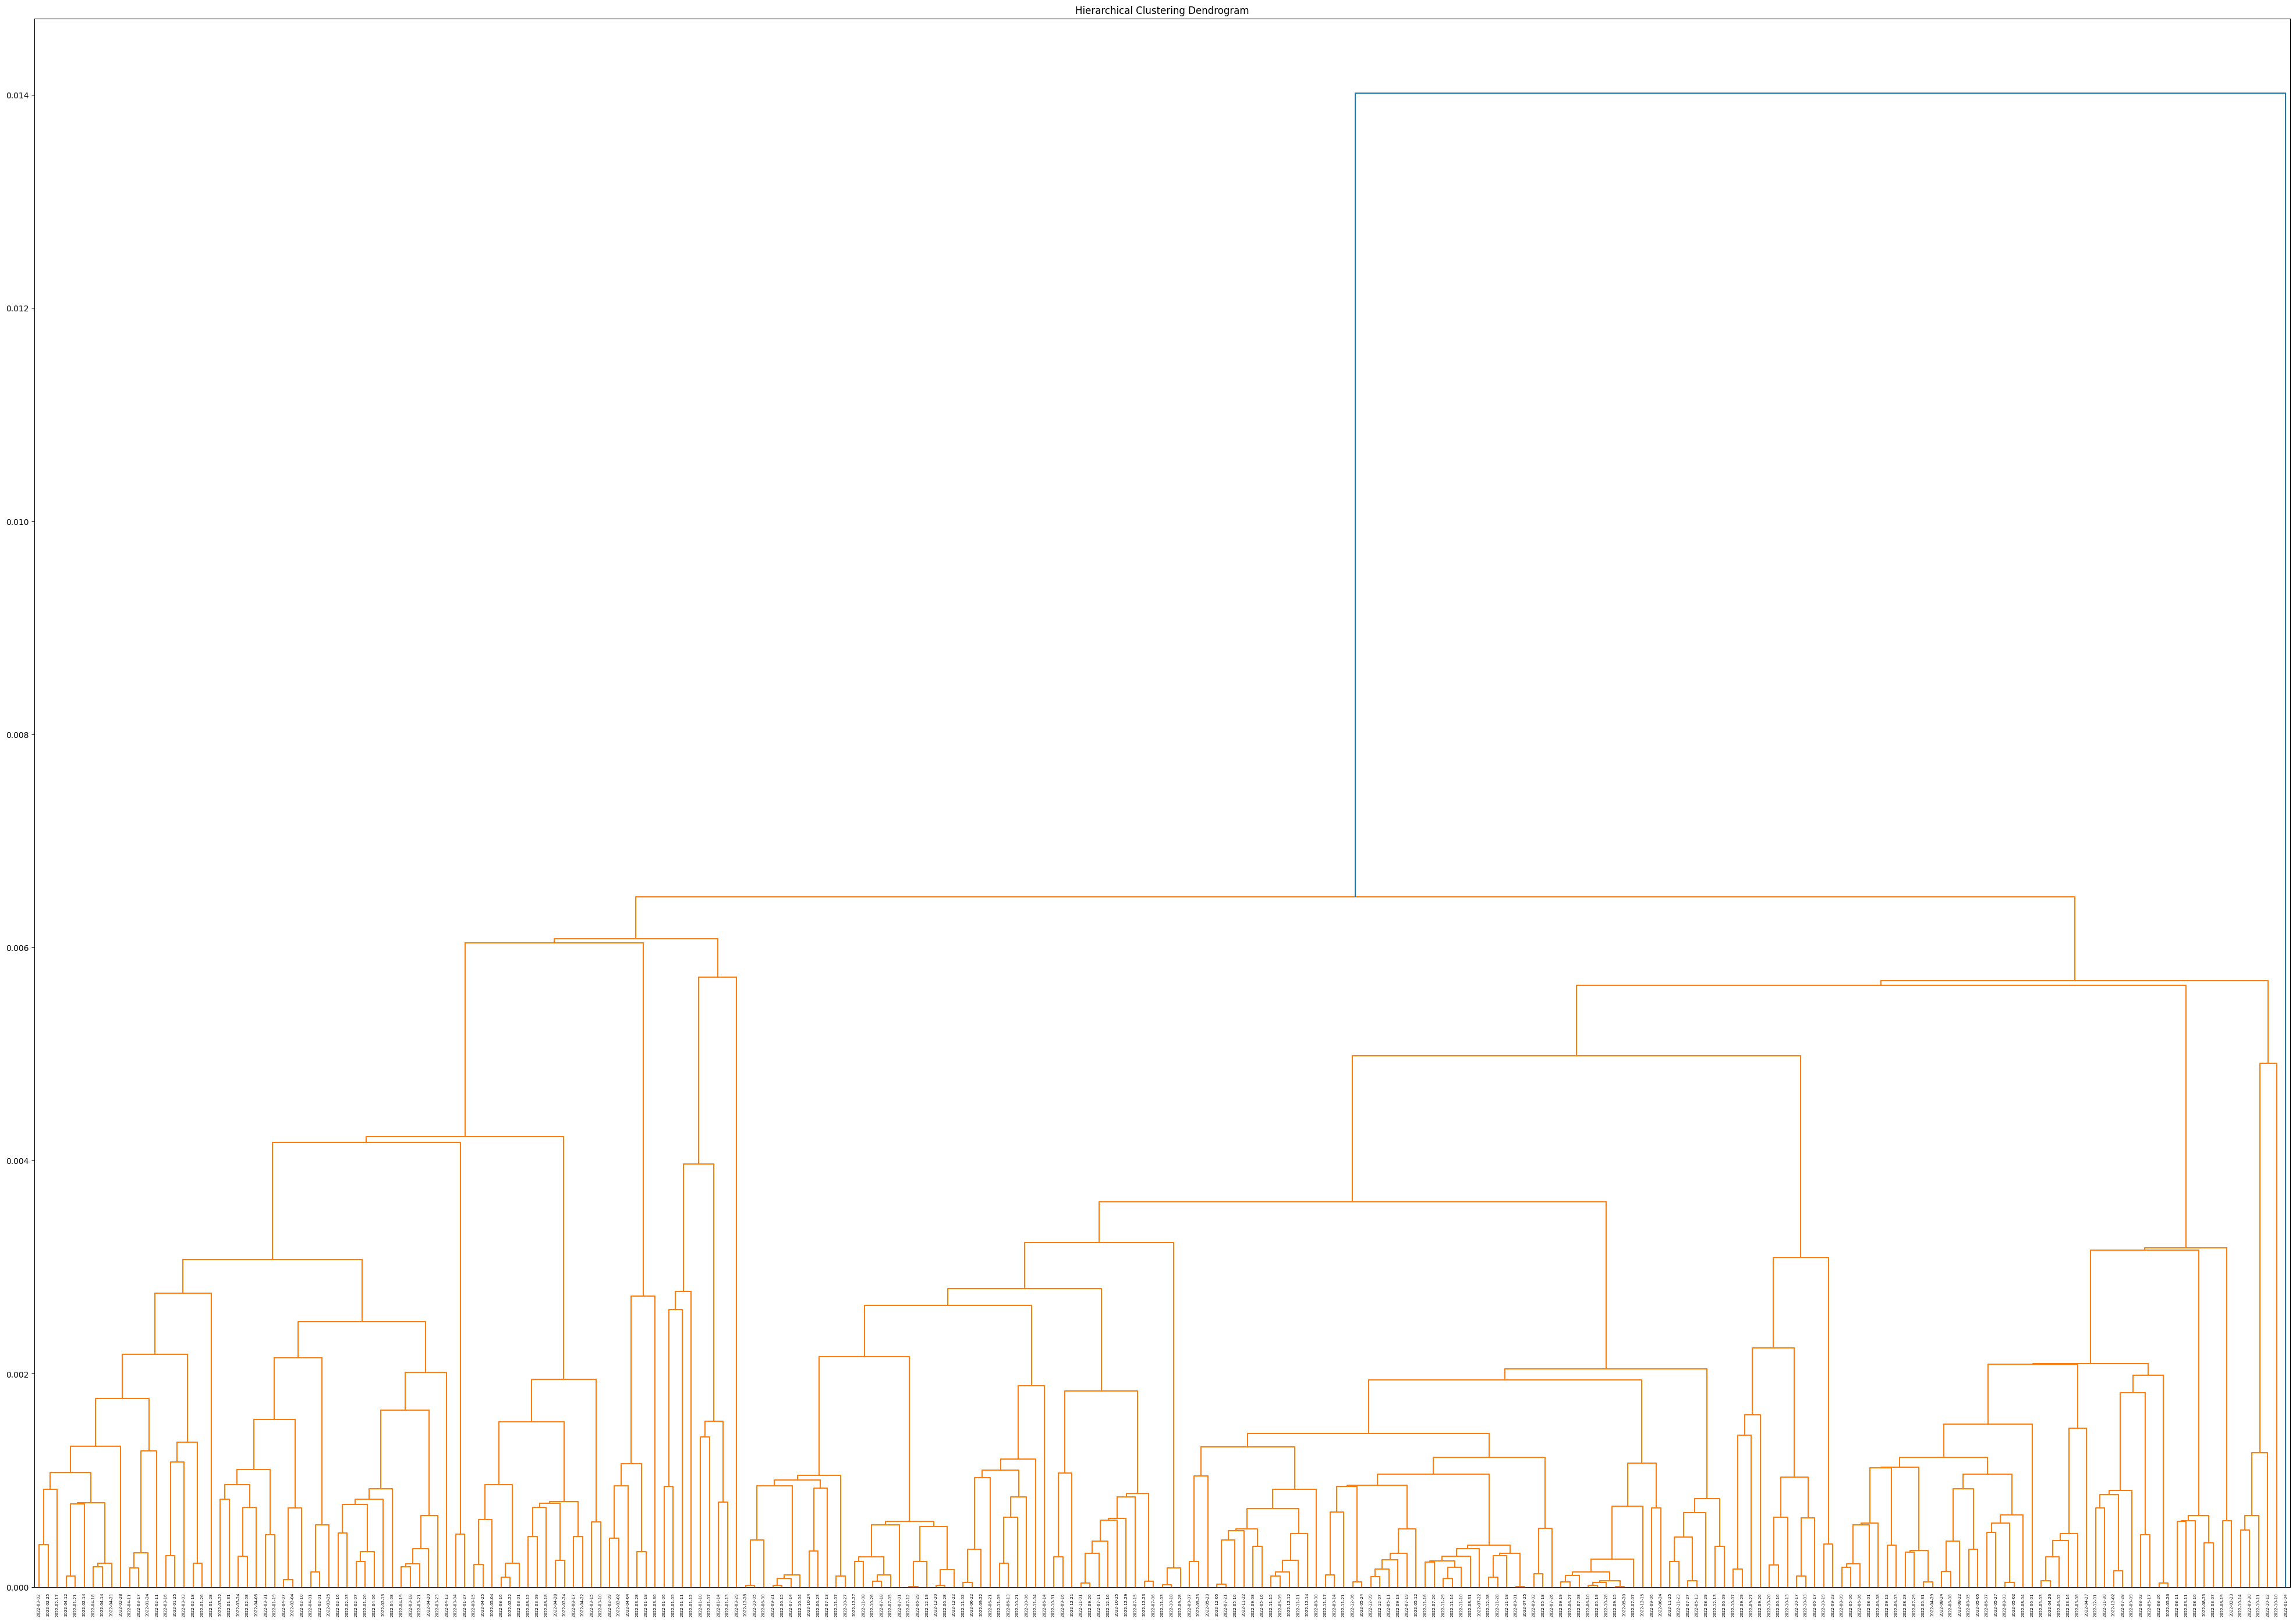

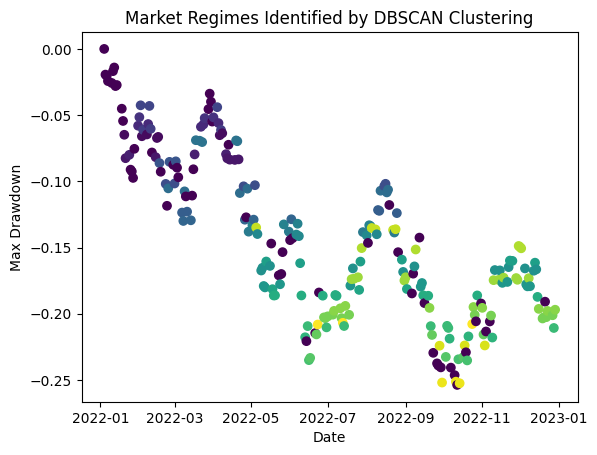

In [32]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def get_sp500_data(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    return sp500

def calculate_max_drawdown(return_series):
    cumulative_returns = (1 + return_series).cumprod()
    running_max = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - running_max) / running_max
    return drawdown

sp500_df = get_sp500_data('2022-01-01', '2022-12-30')


sp500_df['Returns'] = sp500_df['Close'].pct_change()

sp500_df['Max Drawdown'] = calculate_max_drawdown(sp500_df['Returns'])

sp500_df.dropna(inplace=True)

kmeans = KMeans(n_clusters=3, random_state=0).fit(sp500_df[['Max Drawdown']])

sp500_df['KMeans_Cluster'] = kmeans.labels_

plt.scatter(sp500_df.index, sp500_df['Max Drawdown'], c=sp500_df['KMeans_Cluster'], cmap='viridis')
plt.title('Market Regimes Identified by K-Means Clustering')
plt.xlabel('Date')
plt.ylabel('Max Drawdown')
plt.show()
print("")
linked = linkage(sp500_df[['Max Drawdown']], 'single')

plt.figure(figsize=(50, 35))
dendrogram(linked, orientation='top', labels=sp500_df.index.astype(str), distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()
print("")
db = DBSCAN(eps=0.001, min_samples=3).fit(sp500_df[['Max Drawdown']])

sp500_df['DBSCAN_Cluster'] = db.labels_


plt.scatter(sp500_df.index, sp500_df['Max Drawdown'], c=sp500_df['DBSCAN_Cluster'], cmap='viridis')
plt.title('Market Regimes Identified by DBSCAN Clustering')
plt.xlabel('Date')
plt.ylabel('Max Drawdown')
plt.show()
print("")

In [28]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install TA-Lib

--2024-01-22 08:26:55--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-01-22 08:26:56--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://gigenet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-01-22 08:26:56--  http://gigenet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving gigenet.dl.sour

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-validated scores: 0.9950775815944356
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       767
           1       0.96      0.99      0.97       186
           2       0.99      0.99      0.99       195

    accuracy                           0.99      1148
   macro avg       0.98      0.99      0.99      1148
weighted avg       0.99      0.99      0.99      1148

Accuracy: 0.9886759581881533


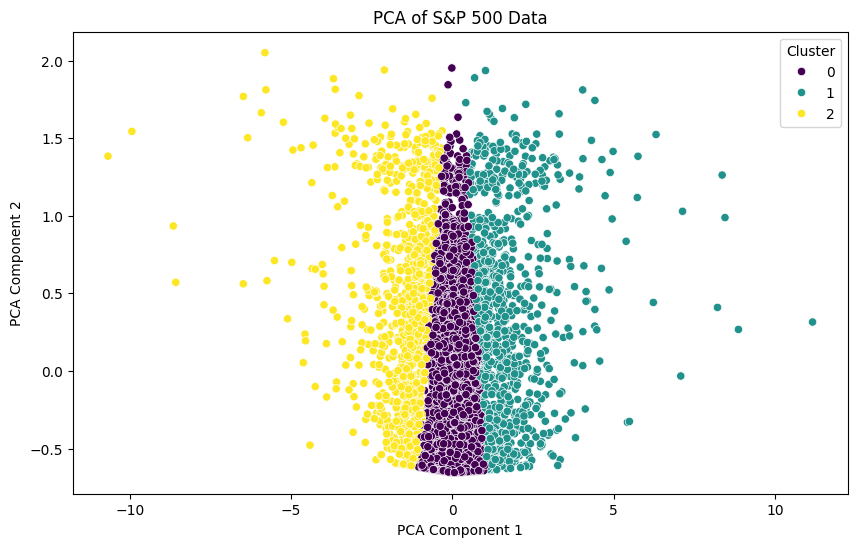

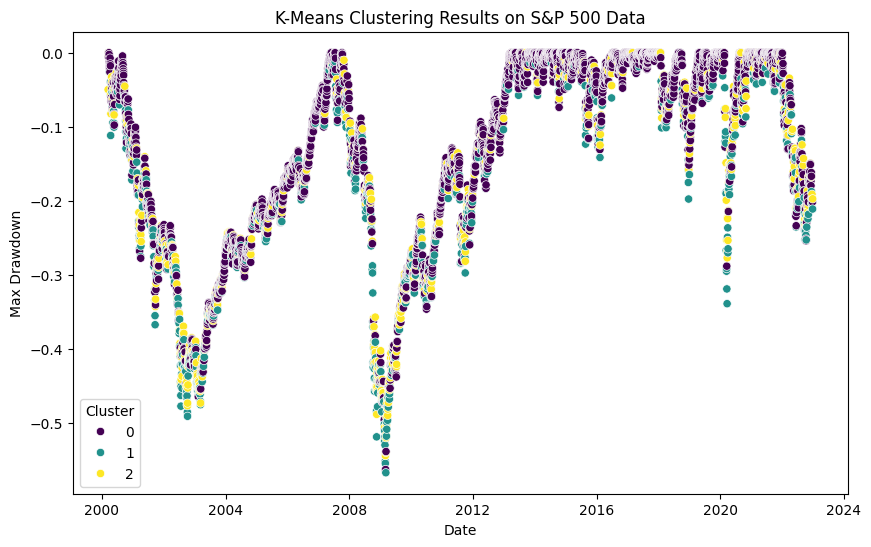

In [36]:
import yfinance as yf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
import talib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get S&P 500 data
def get_sp500_data(start_date, end_date):
    return yf.download('^GSPC', start=start_date, end=end_date)

# Function to calculate max drawdown
def calculate_max_drawdown(return_series):
    cumulative_returns = (1 + return_series).cumprod()
    running_max = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - running_max) / running_max
    return drawdown

# Adding technical indicators
def add_technical_indicators(df):
    df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
    df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
    df.dropna(inplace=True)

# Get the data
sp500_df = get_sp500_data('2000-01-01', '2022-12-30')

# Calculate returns and max drawdown
sp500_df['Returns'] = sp500_df['Close'].pct_change()
sp500_df['Max Drawdown'] = calculate_max_drawdown(sp500_df['Returns'])
sp500_df.dropna(inplace=True)

# Add technical indicators
add_technical_indicators(sp500_df)

# Feature scaling with RobustScaler to mitigate the effect of outliers
robust_scaler = RobustScaler()
scaled_features = robust_scaler.fit_transform(sp500_df[['Max Drawdown', 'Returns']])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
sp500_pca = pca.fit_transform(scaled_features)

# K-Means clustering on PCA-transformed data
kmeans = KMeans(n_clusters=3, random_state=0).fit(sp500_pca)
sp500_df['KMeans_Cluster'] = kmeans.labels_

# Prepare features and labels for the classification model
features = sp500_df[['SMA_50', 'RSI_14', 'Volume', 'Max Drawdown', 'Returns']]
labels = sp500_df['KMeans_Cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

# Oversampling with SMOTE to balance the classes
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_resampled, y_resampled)

# Cross-validated score
scores = cross_val_score(rf_classifier, X_resampled, y_resampled, cv=5)
print(f"Cross-validated scores: {scores.mean()}")

# Make predictions
predictions = rf_classifier.predict(X_test)

# Classification report and accuracy
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

# Visualization of PCA-transformed features
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sp500_pca[:, 0], y=sp500_pca[:, 1], hue=kmeans.labels_, palette='viridis')
plt.title('PCA of S&P 500 Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Visualization of clustering results on original features
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sp500_df.index, y=sp500_df['Max Drawdown'], hue=sp500_df['KMeans_Cluster'], palette='viridis')
plt.title('K-Means Clustering Results on S&P 500 Data')
plt.xlabel('Date')
plt.ylabel('Max Drawdown')
plt.legend(title='Cluster')
plt.show()